# Image classification with logistic regression using tensorflow

In this notebook I present the steps to classify an image using logistic regression through tensorflow. I evaluate the differences between a manual gradient descent programming and the function gradient descent from tensorflow library. I address some issues present in this process such as **zero * zero** multiplications, **nan** and **-inf** values that could emerge using this approach. This issues are present while using the **sigmoid** function as an activation function.


If you encountered some of this complications, that may be reflected in the algorithm not reaching a convergence point or an error in the processing, you could apply the following procedure:
<li>Scale your image array: Divide by 255 your image array so its values oscilate between 0 and 1. What happens if values are not scaled? **zero by zero multiplication**.  
Recall the Cost function  
** L=-mean( ylog(ŷ)+(1-y)log(1-ŷ) ) **   
,the output of the activation function  
**sigmoid(z)=1/(1+exp(-z))**  
and  
**z(x)=X * W+b** .  
If the value of **X** is too high **sigmoid(z)** the factor **exp(-z)** will tend to zero. Therefore, **ŷ = sigmoid(z)=1/(1+0) = 1 **. This will turn **(1-y)log(1-ŷ) = (1-y)log(1-1) = (1-y)log(0) = -inf ** .  
Additionally, if you are assigning the Weight (W) values randomly in a normal distribution with mean zero, this will give you negative factors. If the value of **X** is high this will lead to have **z** to be a big negative number, therefore, **1/(1+exp(-z)) = 1/(1+exp(-(-value))) = 1/(1+(exp(big positive number))) = 1/0 **. Thus a *Nan* value.  
Computanionally, a variable will hold a limited number of digits (Float32, float64) so if the number is too big it will be round to zero or one. Scaling to values between 0 and 1, will solve this issue.
</li>


In [46]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import imp
import sys
sys.path.insert(0, '/home/.../MyLibraries')

import model_score_plot
imp.reload(model_score_plot)
from model_score_plot import ModelScorePlot as MSP

import plot_confusion_matrix_compact
imp.reload(plot_confusion_matrix_compact)
from plot_confusion_matrix_compact import plot_confusion_matrix

import tensorflow as tf
tf.__version__

'1.1.0'

In [47]:
dataset_dir='/home/.../Dataset'
dataset_file='/algae_base_sp_bw_50x50_all.npy'
dataset_location = dataset_dir+'/'+dataset_file
dataset_np = np.load(dataset_location)
print(dataset_np.shape)

Xdata = dataset_np[:,:-1].astype("float32") +0.5
Xdata = Xdata/500.0
Ydata = dataset_np[:,-1:].flatten()#.astype("float32")
targets=list(set(Ydata.tolist()))

Ydata = pd.get_dummies(Ydata)
print(Ydata.shape)

X_train, X_test, y_train, y_test = train_test_split(Xdata,Ydata)

n=Xdata.shape[1]
m=Xdata.shape[0]

t = len(targets)

print("X shape",Xdata.shape,"Y shape",Ydata.shape,"m",m,"n",n,"#Classes",t)
print("Classes:",targets)



(2376, 2501)
(2376, 38)
X shape (2376, 2500) Y shape (2376, 38) m 2376 n 2500 #Classes 38
Classes: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0]


In [42]:
x  = tf.placeholder(tf.float32, shape=[None, n]) #mxn
y = tf.placeholder(tf.float32, shape=[None, t]) #mxt

# Weight tensor
W = tf.Variable(tf.random_normal((n,t),mean=0.5,stddev=0.4,dtype=tf.float32))
# Bias tensor
b = tf.Variable(tf.multiply(tf.ones([t],tf.float32),1.1))

#y_prop = tf.nn.softmax(tf.matmul(x,W) + b)
z = tf.matmul(x,W) + b #mxn
margin=tf.constant(0.0000001)
sigmoid = tf.divide(tf.constant(1.0),tf.constant(1.0)+tf.exp(-z)+margin)
#sigmoid = tf.nn.softmax(z)
sigmoid_log=tf.log(sigmoid)
one_y = tf.multiply(y,sigmoid_log)
sig_comp = 1-sigmoid
sigmoid_logcom = tf.log(sig_comp)
zero_y = tf.multiply((1.0-y),sigmoid_logcom)

logistic_loss_function = tf.add(one_y,zero_y)
logistic_cost_function = tf.reduce_mean(-tf.reduce_sum(logistic_loss_function,1))

learning_rate = 1.0

dJ_dz = tf.subtract(sigmoid,y) #mxt
dJ_dwm = tf.matmul(tf.transpose(x),dJ_dz)
dJ_dw = tf.divide(dJ_dwm,m)# nxm X mxt -> nxt

Wu = tf.subtract(W,tf.multiply(learning_rate,dJ_dw))
ud_w = tf.assign(W,Wu)

dJ_db = tf.reduce_mean(dJ_dz,0)
bu = tf.subtract(b,tf.multiply(learning_rate,dJ_db))
ud_b = tf.assign(b,bu)

training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(logistic_cost_function)

loss_n = tf.Variable(0.0)
loss_n1 = tf.Variable(0.0)
diff_loss = tf.subtract(loss_n,loss_n1)

n_steps=40
convergence_diff_loss = 0.1

init_op = tf.global_variables_initializer()
total_loss = []
loss_diff = []
w_params = np.array([])
b_params = np.array([])

with tf.Session() as s:
    s.run(init_op)
    lcf = s.run(logistic_cost_function,feed_dict={x: Xdata, y: Ydata})
    s.run(tf.assign(loss_n,lcf))
    total_loss.append(lcf)
    print(lcf)
    r1 = s.run([dJ_dz,ud_w,ud_b],feed_dict={x: Xdata, y: Ydata})
    for _ in range(0,n_steps):
        lcf = s.run(logistic_cost_function,feed_dict={x: Xdata, y: Ydata})
        total_loss.append(lcf)
        
        s.run(tf.assign(loss_n1,lcf))
        dl = s.run(diff_loss)
        s.run(tf.assign(loss_n,lcf))
        print("Diff loss",dl)
        loss_diff.append(dl)
        
        if (dl<convergence_diff_loss):
            print("Convergence reached")
            break;
        r1 = s.run([dJ_dz,ud_w,ud_b],feed_dict={x: Xdata, y: Ydata})
    print("End loop")
    w_params = s.run(W)
    b_params = s.run(b)

570.818
Diff loss 27.2964
Diff loss 56.1931
Diff loss 149.338
Diff loss 172.23
Diff loss 65.4575
Diff loss 34.1841
Diff loss 18.314
Diff loss 9.99336
Diff loss 5.83647
Diff loss 4.02249
Diff loss 3.05222
Diff loss 2.24871
Diff loss 1.6638
Diff loss 1.27124
Diff loss 0.997702
Diff loss 0.797197
Diff loss 0.63562
Diff loss 0.503334
Diff loss 0.399208
Diff loss 0.320295
Diff loss 0.261393
Diff loss 0.217533
Diff loss 0.185158
Diff loss 0.161445
Diff loss 0.144481
Diff loss 0.132286
Diff loss 0.123504
Diff loss 0.117249
Diff loss 0.112593
Diff loss 0.109105
Diff loss 0.106544
Diff loss 0.104414
Diff loss 0.102755
Diff loss 0.101418
Diff loss 0.10029
Diff loss 0.0990648
Convergence reached
End loop


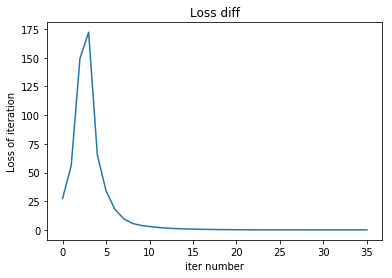

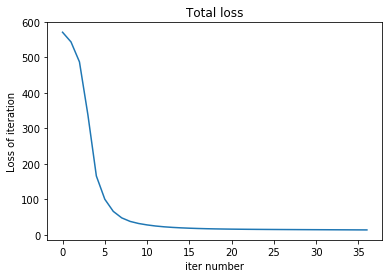

In [43]:
ldl = len(loss_diff)
xr = np.arange(0,ldl)
plt.plot(xr,loss_diff)
plt.title("Loss diff")
plt.xlabel("iter number")
plt.ylabel("Loss of iteration")
plt.show()

ltl = len(total_loss)
xr = np.arange(0,ltl)
plt.plot(xr,total_loss)
plt.title("Total loss")
plt.xlabel("iter number")
plt.ylabel("Loss of iteration")
plt.show()

In [44]:
total_loss_auto = []
loss_diff_auto=[]
w_params_auto = np.array([])
b_params_auto = np.array([])
with tf.Session() as s:
    s.run(init_op)
    ts,lcf = s.run([training_step,logistic_cost_function],feed_dict={x: Xdata, y: Ydata})
    s.run(tf.assign(loss_n,lcf))
    total_loss_auto.append(lcf)
    print(lcf)
    for _ in range(0,n_steps):
        ts,lcf = s.run([training_step,logistic_cost_function],feed_dict={x: Xdata, y: Ydata})
        total_loss_auto.append(lcf)
        
        s.run(tf.assign(loss_n1,lcf))
        dl = s.run(diff_loss)
        s.run(tf.assign(loss_n,lcf))
        print("Diff loss",dl)
        loss_diff_auto.append(dl)
        if (dl<convergence_diff_loss):
            print("Convergence reached")
            break;
    print("End loop")
    w_params_auto = s.run(W)
    b_params_auto = s.run(b)

570.988
Diff loss 1.68005
Diff loss 1.92987
Diff loss 2.24237
Diff loss 2.54425
Diff loss 2.84369
Diff loss 3.16516
Diff loss 3.49164
Diff loss 3.80243
Diff loss 4.17572
Diff loss 4.60822
Diff loss 5.18842
Diff loss 5.94879
Diff loss 7.04498
Diff loss 8.53265
Diff loss 10.6357
Diff loss 13.5462
Diff loss 18.2425
Diff loss 24.5687
Diff loss 31.7645
Diff loss 41.3643
Diff loss 46.8642
Diff loss 45.8343
Diff loss 43.0672
Diff loss 42.3167
Diff loss 36.4778
Diff loss 28.1162
Diff loss 24.0846
Diff loss 19.7009
Diff loss 15.0867
Diff loss 12.1532
Diff loss 9.85264
Diff loss 7.89309
Diff loss 6.1917
Diff loss 4.69834
Diff loss 3.56711
Diff loss 2.6715
Diff loss 1.93909
Diff loss 1.39485
Diff loss 0.994556
Diff loss 0.741508
End loop


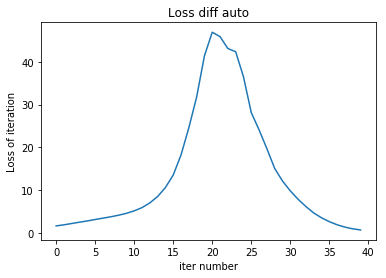

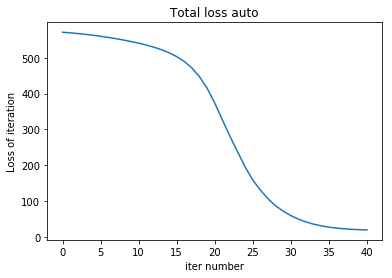

In [45]:
ldl = len(loss_diff_auto)
xr = np.arange(0,ldl)
plt.plot(xr,loss_diff_auto)
plt.title("Loss diff auto")
plt.xlabel("iter number")
plt.ylabel("Loss of iteration")
plt.show()

ltl = len(total_loss_auto)
xr = np.arange(0,ltl)
plt.plot(xr,total_loss_auto)
plt.title("Total loss auto")
plt.xlabel("iter number")
plt.ylabel("Loss of iteration")
plt.show()

### Observations

When the **z** matrix values are "too" high, the sigmoid function becomes one. This is not desirable because the logistic loss function factor log(1-sigmoid) turns into log(1-1) = log (0) = -inf, which can't be used for computational processes. Consider that when working with images the highest possible value in the matrix is 255. If a pixel of value of intensity is ~20 and is multiplied by any **Weight** equivalent to 1 or above, this will produce a **1** value in its sigmoid transformation. Thus, if is required to scale the image matrix to a possible range between zero and 1 by dividing the matrix by 255.

[ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96]
(20,)
Exp factor:
[  3.67879450e-01   2.47875229e-03   1.67017006e-05   1.12535176e-07
   7.58256014e-10   5.10908937e-12   3.44247708e-14   2.31952296e-16
   1.56288218e-18   1.05306175e-20   7.09547441e-23   4.78089300e-25
   3.22134028e-27   2.17052199e-29   1.46248624e-31   9.85415445e-34
   6.63967696e-36   4.47377931e-38   0.00000000e+00   0.00000000e+00]
Sigmoid:
[ 0.7310586   0.99752742  0.99998331  0.99999988  1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.        ]


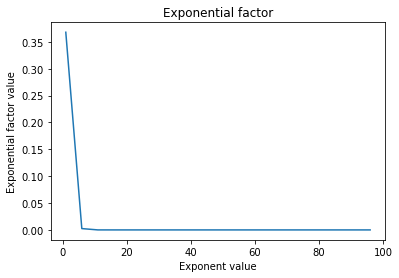

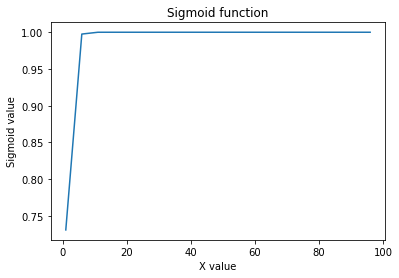

In [58]:
x_in = tf.placeholder(tf.float32)
exp_f = tf.exp(-x_in)
sigmoidx = tf.divide(1.0,1.0+exp_f)
xexp = np.arange(1,100,5)
print(xexp)
print(xexp.shape)
expl = np.array([])
sigl = np.array([])
with tf.Session() as s:
    r1,r2 = s.run([exp_f,sigmoidx],feed_dict={x_in:xexp})
    print("Exp factor:")
    print(r1)
    print("Sigmoid:")
    print(r2)
    expl = r1
    sigl = r2

plt.plot(xexp,expl)
plt.title("Exponential factor")
plt.xlabel("Exponent value")
plt.ylabel("Exponential factor value")
plt.show()

plt.plot(xexp,sigl)
plt.title("Sigmoid function")
plt.xlabel("X value")
plt.ylabel("Sigmoid value")
plt.show()